# Model Performance Evaluation

This notebook provides comprehensive performance evaluation for mass spectrometry prediction models trained in the previous pipeline. It focuses on quantitative metrics, statistical significance testing, and performance comparisons between all trained models including:
- Random Forest
- K-Nearest Neighbors (Optimized)
- ModularNet
- HierarchicalPredictionNet
- SparseGatedNet
- RegionalExpertNet
- Simple Weighted Ensemble
- Bin-by-bin Ensemble

## Overview

The evaluation framework implements:

### 1. Spectral Similarity Metrics
- **Cosine Similarity**: Shape-based similarity independent of absolute intensity
- **Weighted Dot Product (WDP)**: NIST standard with m/z weighting
- **Spectral Angle**: Geometric angle between spectral vectors
- **Spectral Entropy Similarity**: Information-theoretic measure
- **Stein Dot Product**: Industry standard for spectral library searching

### 2. Peak Detection Metrics
- Precision, Recall, and F1 scores at multiple thresholds
- Intensity-weighted recall for peak importance
- Confusion matrix analysis

### 3. Statistical Significance Testing
- Bootstrap confidence intervals (95% CI)
- Paired t-tests with Bonferroni correction
- Effect size calculation (Cohen's d)

## Mathematical Foundation

### Cosine Similarity
$$\cos(\theta) = \frac{\mathbf{s}_1 \cdot \mathbf{s}_2}{||\mathbf{s}_1|| \cdot ||\mathbf{s}_2||} = \frac{\sum_{i=1}^{n} s_{1i} s_{2i}}{\sqrt{\sum_{i=1}^{n} s_{1i}^2} \cdot \sqrt{\sum_{i=1}^{n} s_{2i}^2}}$$

### Weighted Dot Product (WDP)
$$\text{WDP} = \frac{\sum_{i=1}^{n} \sqrt{s_{1i} \cdot s_{2i}} \cdot w_i}{\sqrt{\sum_{i=1}^{n} s_{1i} \cdot w_i} \cdot \sqrt{\sum_{i=1}^{n} s_{2i} \cdot w_i}}$$
where $w_i = \sqrt{i}$ gives higher weight to higher m/z values.

### Bootstrap Confidence Interval
For metric $\theta$:
1. Generate B bootstrap samples by resampling with replacement
2. Calculate $\theta_b^*$ for each bootstrap sample
3. 95% CI: $[\theta_{0.025}^*, \theta_{0.975}^*]$

## Input Requirements
- Trained models from notebook 04
- Test data with ground truth spectra
- Model predictions saved during training

## Output
- Comprehensive performance metrics with confidence intervals
- Statistical significance tests between models
- Performance summary tables and visualizations

## 1. Environment Setup

Import all required libraries and configure the environment for model evaluation.

In [1]:
import os
import json
import pickle
import warnings
import logging
import time
from typing import Dict, Any, Tuple, List, Optional, Union
from dataclasses import dataclass
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy import stats
from scipy.spatial.distance import cosine, euclidean, cityblock
from scipy.stats import ttest_rel, wilcoxon

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    median_absolute_error, explained_variance_score
)
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

N_JOBS = min(multiprocessing.cpu_count() - 1, 16)
print(f"Using {N_JOBS} cores for parallel processing")

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.major.size': 6,
    'ytick.minor.size': 3,
    'legend.frameon': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

MODEL_COLORS = {
    'Random Forest': '#27ae60',
    'KNN': '#e74c3c',
    'ModularNet': '#8e44ad',
    'HierarchicalPredictionNet': '#16a085',
    'SparseGatedNet': '#d35400',
    'RegionalExpertNet': '#2c3e50',
    'Simple Weighted Ensemble': '#f39c12',
    'Bin-by-bin Ensemble': '#3498db'
}

print("Environment setup complete")

Using device: mps
Using 15 cores for parallel processing
Environment setup complete


## 2. Evaluation Configuration

Central configuration hub for all evaluation parameters.

In [2]:
EVAL_CONFIG = {
    'paths': {
        'models_dir': '../models',
        'results_dir': '../data/results',
        'figures_dir': '../figures/evaluation',
        'input_type': 'hpj'
    },
    'evaluation': {
        'peak_thresholds': [0.01, 0.05, 0.1],
        'bin_size': 1.0,
        'n_bootstrap': 1000,
        'confidence_level': 0.95,
        'significance_alpha': 0.05,
        'transform_sqrt': True
    },
    'metrics': {
        'primary': 'cosine_similarity',
        'calculate_all': True,
        'parallel': True
    }
}

os.makedirs(EVAL_CONFIG['paths']['results_dir'], exist_ok=True)
os.makedirs(EVAL_CONFIG['paths']['figures_dir'], exist_ok=True)

print(f"Evaluation configuration loaded")
print(f"Results will be saved to: {EVAL_CONFIG['paths']['results_dir']}")
print(f"Figures will be saved to: {EVAL_CONFIG['paths']['figures_dir']}")

Evaluation configuration loaded
Results will be saved to: ../data/results
Figures will be saved to: ../figures/evaluation


## 3. Data Classes for Metrics

Structured data containers for organizing evaluation metrics.

In [3]:
@dataclass
class SpectralMetrics:
    """Container for spectral similarity metrics with confidence intervals"""
    cosine_similarity: float
    cosine_similarity_ci: Tuple[float, float]
    weighted_dot_product: float
    weighted_dot_product_ci: Tuple[float, float]
    spectral_angle: float
    spectral_angle_ci: Tuple[float, float]
    stein_dot_product: float
    spectral_entropy_similarity: float
    euclidean_similarity: float
    manhattan_similarity: float
    pearson_correlation: float
    spearman_correlation: float
    mean_absolute_error: float
    root_mean_squared_error: float
    r2_score: float
    explained_variance: float

@dataclass
class PeakDetectionMetrics:
    """Container for peak detection metrics at a specific threshold"""
    threshold: float
    precision: float
    precision_ci: Tuple[float, float]
    recall: float
    recall_ci: Tuple[float, float]
    f1_score: float
    f1_score_ci: Tuple[float, float]
    true_positives: int
    false_positives: int
    false_negatives: int
    true_negatives: int
    intensity_weighted_recall: float
    intensity_weighted_precision: float

@dataclass
class ModelEvaluationResults:
    """Comprehensive evaluation results for a single model"""
    model_name: str
    spectral_metrics: SpectralMetrics
    peak_detection_metrics: Dict[float, PeakDetectionMetrics]
    sample_cosine_similarities: np.ndarray
    sample_wdp_scores: np.ndarray
    evaluation_time_seconds: float
    n_test_samples: int
    n_mz_bins: int

## 4. Neural Network Architecture Definitions

Define all neural network architectures needed for loading the trained models.

In [4]:
class ModularNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        num_modules = config['num_modules']
        module_dims = config['module_dims']
        fusion_method = config['fusion_method']
        
        self.global_encoder = nn.Sequential(
            nn.Linear(input_dim, module_dims[0]),
            nn.BatchNorm1d(module_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.specialized_modules = nn.ModuleList()
        
        for i in range(num_modules):
            module_layers = []
            dims = [input_dim] + module_dims
            
            for j in range(len(module_dims)):
                module_layers.extend([
                    nn.Linear(dims[j], dims[j+1]),
                    nn.BatchNorm1d(dims[j+1]),
                    nn.ReLU(),
                    nn.Dropout(0.1)
                ])
            
            module_layers.append(nn.Linear(module_dims[-1], output_dim))
            module_layers.append(nn.ReLU())
            
            self.specialized_modules.append(nn.Sequential(*module_layers))
        
        if fusion_method == 'attention':
            self.fusion_attention = nn.Sequential(
                nn.Linear(module_dims[0], num_modules),
                nn.Softmax(dim=1)
            )
        else:
            self.fusion_weights = nn.Parameter(torch.ones(num_modules) / num_modules)
    
    def forward(self, x):
        global_features = self.global_encoder(x)
        module_outputs = []
        for module in self.specialized_modules:
            output = module(x)
            module_outputs.append(output)
        
        module_outputs = torch.stack(module_outputs, dim=1)
        
        if hasattr(self, 'fusion_attention'):
            attention_weights = self.fusion_attention(global_features)
            attention_weights = attention_weights.unsqueeze(2)
            fused_output = (module_outputs * attention_weights).sum(dim=1)
        else:
            weights = F.softmax(self.fusion_weights, dim=0)
            weights = weights.view(1, -1, 1)
            fused_output = (module_outputs * weights).sum(dim=1)
        
        return fused_output

class HierarchicalPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        presence_hidden = config['presence_hidden']
        intensity_hidden = config['intensity_hidden']
        self.presence_threshold = config['presence_threshold']
        conditional_dropout = config['conditional_dropout']
        
        presence_layers = []
        dims = [input_dim] + presence_hidden
        
        for i in range(len(presence_hidden)):
            presence_layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
        
        presence_layers.append(nn.Linear(presence_hidden[-1], output_dim))
        self.presence_net = nn.Sequential(*presence_layers)
        
        intensity_input_dim = input_dim + output_dim
        intensity_layers = []
        dims = [intensity_input_dim] + intensity_hidden
        
        for i in range(len(intensity_hidden)):
            intensity_layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(conditional_dropout)
            ])
        
        intensity_layers.append(nn.Linear(intensity_hidden[-1], output_dim))
        intensity_layers.append(nn.ReLU())
        self.intensity_net = nn.Sequential(*intensity_layers)
        
        self.calibration = nn.Sequential(
            nn.Linear(output_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.hierarchical_forward = True
    
    def forward(self, x, return_presence=False):
        presence_logits = self.presence_net(x)
        presence_probs = torch.sigmoid(presence_logits)
        
        conditional_input = torch.cat([x, presence_probs], dim=1)
        intensities = self.intensity_net(conditional_input)
        
        calibration_weights = self.calibration(intensities)
        output = intensities * presence_probs * calibration_weights
        
        if return_presence:
            return output, presence_logits
        return output

class SparseGatingLayer(nn.Module):
    def __init__(self, input_dim, gate_hidden, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        
        self.gate_net = nn.Sequential(
            nn.Linear(input_dim, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, input_dim),
            nn.Sigmoid()
        )
        
        self.sparse_path = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.dense_path = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        gates = self.gate_net(x) / self.temperature
        sparse_out = self.sparse_path(x)
        dense_out = self.dense_path(x)
        output = gates * dense_out + (1 - gates) * sparse_out
        return output, gates

class SparseGatedNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        hidden_dims = config['hidden_dims']
        gate_hidden = config['gate_hidden']
        temperature = config['gate_temperature']
        
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        self.input_bn = nn.BatchNorm1d(hidden_dims[0])
        
        self.gated_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.gated_layers.append(
                SparseGatingLayer(hidden_dims[i], gate_hidden, temperature)
            )
        
        self.transitions = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.transitions.append(
                nn.Linear(hidden_dims[i], hidden_dims[i+1])
            )
        
        self.output_sparse = nn.Linear(hidden_dims[-1], output_dim)
        self.output_dense = nn.Linear(hidden_dims[-1], output_dim)
        self.output_gate = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.input_proj(x)
        x = self.input_bn(x)
        x = F.relu(x)
        
        for gated_layer, transition in zip(self.gated_layers, self.transitions):
            x, _ = gated_layer(x)
            x = transition(x)
            x = F.relu(x)
        
        sparse_pred = F.relu(self.output_sparse(x))
        dense_pred = F.relu(self.output_dense(x))
        output_gates = self.output_gate(x)
        
        output = output_gates * dense_pred + (1 - output_gates) * sparse_pred * 0.1
        
        return output

class RegionalExpert(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        
        layers = []
        dims = [input_dim] + hidden_dims
        
        for i in range(len(hidden_dims)):
            layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
        
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.ReLU())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class RegionalExpertNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        self.expert_regions = config['expert_regions']
        expert_hidden = config['expert_hidden']
        router_hidden = config['router_hidden']
        self.overlap_bins = config['overlap_bins']
        
        self.experts = nn.ModuleList()
        for start, end in self.expert_regions:
            expert_output_dim = end - start + 2 * self.overlap_bins
            self.experts.append(
                RegionalExpert(input_dim, expert_output_dim, expert_hidden)
            )
        
        self.router = nn.Sequential(
            nn.Linear(input_dim, router_hidden),
            nn.ReLU(),
            nn.Linear(router_hidden, len(self.expert_regions)),
            nn.Softmax(dim=1)
        )
        
        self.global_features = nn.Sequential(
            nn.Linear(input_dim, router_hidden),
            nn.BatchNorm1d(router_hidden),
            nn.ReLU()
        )
    
    def forward(self, x):
        routing_weights = self.router(x)
        global_feat = self.global_features(x)
        
        output = torch.zeros(x.shape[0], 500).to(x.device)
        
        for i, ((start, end), expert) in enumerate(zip(self.expert_regions, self.experts)):
            expert_pred = expert(x)
            
            actual_start = max(0, start - self.overlap_bins)
            actual_end = min(500, end + self.overlap_bins)
            
            region_size = actual_end - actual_start
            if expert_pred.shape[1] >= region_size:
                weighted_pred = expert_pred[:, :region_size] * routing_weights[:, i:i+1]
                output[:, actual_start:actual_end] += weighted_pred
        
        return output

print("Neural network architectures defined")

Neural network architectures defined


## 5. Spectral Similarity Metrics Implementation

Comprehensive implementation of spectral similarity metrics for mass spectrometry data evaluation.

### Key Metrics:

#### 1. Cosine Similarity
$$\cos(\theta) = \frac{\mathbf{s}_1 \cdot \mathbf{s}_2}{||\mathbf{s}_1|| \cdot ||\mathbf{s}_2||}$$

#### 2. Weighted Dot Product (WDP)
$$\text{WDP} = \frac{\sum_{i=1}^{n} \sqrt{s_{1i} \cdot s_{2i}} \cdot \sqrt{i}}{\sqrt{\sum_{i=1}^{n} s_{1i} \cdot \sqrt{i}} \cdot \sqrt{\sum_{i=1}^{n} s_{2i} \cdot \sqrt{i}}}$$

#### 3. Stein Dot Product
$$\text{SDP} = \frac{\sum_{i=1}^{n} (s_{1i})^n (s_{2i})^n (m/z_i)^m}{\sqrt{\sum_{i=1}^{n} (s_{1i})^{2n} (m/z_i)^{2m}} \cdot \sqrt{\sum_{i=1}^{n} (s_{2i})^{2n} (m/z_i)^{2m}}}$$

#### 4. Spectral Entropy Similarity
$$\text{SES} = 1 - \frac{2H(\mathbf{s}_{avg}) - H(\mathbf{s}_1) - H(\mathbf{s}_2)}{2H(\mathbf{s}_{avg})}$$

In [5]:
class SpectralSimilarityCalculator:
    """Calculate various spectral similarity metrics between mass spectra"""
    
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.transform_sqrt = config['evaluation']['transform_sqrt']
    
    @staticmethod
    def normalize_spectrum(spectrum: np.ndarray, method: str = 'l2') -> np.ndarray:
        """Normalize spectrum using specified method"""
        if method == 'l2':
            norm = np.linalg.norm(spectrum)
            return spectrum / norm if norm > 0 else spectrum
        elif method == 'sum':
            total = np.sum(spectrum)
            return spectrum / total if total > 0 else spectrum
        elif method == 'max':
            max_val = np.max(spectrum)
            return spectrum / max_val if max_val > 0 else spectrum
        else:
            return spectrum
    
    def cosine_similarity(self, spec1: np.ndarray, spec2: np.ndarray) -> float:
        """Calculate cosine similarity between two spectra"""
        if np.sum(spec1) == 0 or np.sum(spec2) == 0:
            return 0.0
        return 1 - cosine(spec1, spec2)
    
    def weighted_dot_product(self, spec1: np.ndarray, spec2: np.ndarray) -> float:
        """Calculate weighted dot product (WDP) with m/z weighting - FIXED"""
        n_bins = len(spec1)
        mz_values = np.arange(1, n_bins + 1)
        mz_weights = np.sqrt(mz_values)  # Square root weighting
        
        numerator = np.sum(np.sqrt(spec1 * spec2) * mz_weights)
        # FIX: Use mz_weights in denominator, not mz_values
        denominator = np.sqrt(np.sum(spec1 * mz_weights)) * np.sqrt(np.sum(spec2 * mz_weights))
        
        if denominator == 0:
            return 0.0
        
        return numerator / denominator
    
    def spectral_angle(self, spec1: np.ndarray, spec2: np.ndarray) -> float:
        """Calculate spectral angle similarity"""
        cos_sim = self.cosine_similarity(spec1, spec2)
        cos_sim = np.clip(cos_sim, -1.0, 1.0)
        angle = np.arccos(cos_sim)
        return 1 - (angle / np.pi)
    
    def stein_dot_product(self, spec1: np.ndarray, spec2: np.ndarray, 
                         n: float = 0.5, m: float = 3.0) -> float:
        """Calculate Stein dot product (NIST standard)"""
        n_bins = len(spec1)
        mz_values = np.arange(1, n_bins + 1)
        
        weighted_spec1 = np.power(spec1, n) * np.power(mz_values, m)
        weighted_spec2 = np.power(spec2, n) * np.power(mz_values, m)
        
        dot_product = np.dot(weighted_spec1, weighted_spec2)
        norm1 = np.linalg.norm(weighted_spec1)
        norm2 = np.linalg.norm(weighted_spec2)
        
        if norm1 * norm2 == 0:
            return 0.0
        
        return dot_product / (norm1 * norm2)
    
    def spectral_entropy_similarity(self, spec1: np.ndarray, spec2: np.ndarray) -> float:
        """Calculate spectral entropy similarity"""
        def entropy(spectrum):
            if np.sum(spectrum) == 0:
                return 0.0
            prob = spectrum / np.sum(spectrum)
            prob = prob[prob > 0]
            return -np.sum(prob * np.log(prob))
        
        merged = (spec1 + spec2) / 2
        
        entropy1 = entropy(spec1)
        entropy2 = entropy(spec2)
        entropy_merged = entropy(merged)
        
        if entropy_merged == 0:
            return 1.0 if entropy1 == 0 and entropy2 == 0 else 0.0
        
        return 1 - (2 * entropy_merged - entropy1 - entropy2) / (2 * entropy_merged)
    
    def calculate_all_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate all spectral similarity metrics"""
        metrics = {}
        
        y_true = np.maximum(y_true, 0)
        y_pred = np.maximum(y_pred, 0)
        
        metrics['cosine_similarity'] = self.cosine_similarity(y_true, y_pred)
        metrics['weighted_dot_product'] = self.weighted_dot_product(y_true, y_pred)
        metrics['spectral_angle'] = self.spectral_angle(y_true, y_pred)
        metrics['stein_dot_product'] = self.stein_dot_product(y_true, y_pred)
        metrics['spectral_entropy_similarity'] = self.spectral_entropy_similarity(y_true, y_pred)
        
        metrics['euclidean_similarity'] = 1 / (1 + euclidean(y_true, y_pred))
        metrics['manhattan_similarity'] = 1 / (1 + cityblock(y_true, y_pred))
        
        if np.std(y_true) > 0 and np.std(y_pred) > 0:
            metrics['pearson_correlation'] = np.corrcoef(y_true, y_pred)[0, 1]
            metrics['spearman_correlation'] = stats.spearmanr(y_true, y_pred)[0]
        else:
            metrics['pearson_correlation'] = 0.0
            metrics['spearman_correlation'] = 0.0
        
        metrics['mean_absolute_error'] = mean_absolute_error(y_true, y_pred)
        metrics['root_mean_squared_error'] = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics['r2_score'] = r2_score(y_true, y_pred)
        metrics['explained_variance'] = explained_variance_score(y_true, y_pred)
        
        return metrics

print("Spectral similarity calculator initialized")

Spectral similarity calculator initialized


## 6. Peak Detection Evaluation

Implementation of peak detection metrics.

### Peak Detection Metrics

Evaluates binary classification performance:
- **Precision**: $\frac{TP}{TP + FP}$
- **Recall**: $\frac{TP}{TP + FN}$
- **F1 Score**: $2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$
- **Intensity-Weighted Recall**: $\frac{\sum I_{pred} \cdot \mathbb{1}_{true}}{\sum I_{true}}$

In [6]:
class PeakDetectionEvaluator:
    """Evaluate peak detection performance at various thresholds"""
    
    def __init__(self, thresholds: List[float]):
        self.thresholds = thresholds
    
    def evaluate_single_spectrum(self, y_true: np.ndarray, y_pred: np.ndarray, 
                               threshold: float) -> Dict[str, float]:
        """Evaluate peak detection for a single spectrum"""
        if np.max(y_true) > 0:
            y_true_norm = y_true / np.max(y_true)
        else:
            y_true_norm = y_true
            
        if np.max(y_pred) > 0:
            y_pred_norm = y_pred / np.max(y_pred)
        else:
            y_pred_norm = y_pred
        
        true_peaks = y_true_norm > threshold
        pred_peaks = y_pred_norm > threshold
        
        tp = np.sum(true_peaks & pred_peaks)
        fp = np.sum(~true_peaks & pred_peaks)
        fn = np.sum(true_peaks & ~pred_peaks)
        tn = np.sum(~true_peaks & ~pred_peaks)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        if np.sum(y_true[true_peaks]) > 0:
            intensity_weighted_recall = np.sum(y_pred[true_peaks]) / np.sum(y_true[true_peaks])
        else:
            intensity_weighted_recall = 0.0
            
        if np.sum(y_pred[pred_peaks]) > 0:
            intensity_weighted_precision = np.sum(y_true[pred_peaks]) / np.sum(y_pred[pred_peaks])
        else:
            intensity_weighted_precision = 0.0
        
        return {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': int(tp),
            'false_positives': int(fp),
            'false_negatives': int(fn),
            'true_negatives': int(tn),
            'intensity_weighted_recall': intensity_weighted_recall,
            'intensity_weighted_precision': intensity_weighted_precision
        }
    
    def evaluate_dataset(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[float, PeakDetectionMetrics]:
        """Evaluate peak detection across all samples and thresholds"""
        results = {}
        
        for threshold in self.thresholds:
            all_metrics = []
            
            for i in range(len(y_true)):
                metrics = self.evaluate_single_spectrum(y_true[i], y_pred[i], threshold)
                all_metrics.append(metrics)
            
            df_metrics = pd.DataFrame(all_metrics)
            
            precision_ci = self._bootstrap_ci(df_metrics['precision'].values)
            recall_ci = self._bootstrap_ci(df_metrics['recall'].values)
            f1_ci = self._bootstrap_ci(df_metrics['f1_score'].values)
            
            results[threshold] = PeakDetectionMetrics(
                threshold=threshold,
                precision=df_metrics['precision'].mean(),
                precision_ci=precision_ci,
                recall=df_metrics['recall'].mean(),
                recall_ci=recall_ci,
                f1_score=df_metrics['f1_score'].mean(),
                f1_score_ci=f1_ci,
                true_positives=df_metrics['true_positives'].sum(),
                false_positives=df_metrics['false_positives'].sum(),
                false_negatives=df_metrics['false_negatives'].sum(),
                true_negatives=df_metrics['true_negatives'].sum(),
                intensity_weighted_recall=df_metrics['intensity_weighted_recall'].mean(),
                intensity_weighted_precision=df_metrics['intensity_weighted_precision'].mean()
            )
        
        return results
    
    def _bootstrap_ci(self, values: np.ndarray, n_bootstrap: int = 1000, 
                     confidence: float = 0.95) -> Tuple[float, float]:
        """Calculate bootstrap confidence interval"""
        bootstrap_means = []
        n_samples = len(values)
        
        for _ in range(n_bootstrap):
            bootstrap_sample = np.random.choice(values, size=n_samples, replace=True)
            bootstrap_means.append(np.mean(bootstrap_sample))
        
        alpha = 1 - confidence
        lower = np.percentile(bootstrap_means, alpha/2 * 100)
        upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)
        
        return (lower, upper)

print("Peak detection evaluator initialized")

Peak detection evaluator initialized


## 7. Model Loading and Data Preparation

Load all trained models and prepare test data for evaluation.

In [7]:
class ModelLoader:
    """Handle loading of trained models and test data"""
    
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.models = {}
        self.predictions = {}
        self.data = {}
    
    def load_all_predictions(self) -> Dict[str, np.ndarray]:
        """Load all model predictions from saved files"""
        models_dir = self.config['paths']['models_dir']
        
        all_predictions_path = os.path.join(models_dir, 'all_model_predictions.pkl')
        if os.path.exists(all_predictions_path):
            with open(all_predictions_path, 'rb') as f:
                predictions_data = pickle.load(f)
            
            self.predictions = predictions_data['predictions']
            self.data['y_test'] = predictions_data['y_true']
            self.data['test_smiles'] = predictions_data.get('test_smiles', [])
            self.data['X_test'] = predictions_data.get('X_test', np.array([]))
            self.data['scaler'] = predictions_data.get('scaler', None)
            
            logger.info(f"Loaded predictions for {len(self.predictions)} models")
            logger.info(f"Models: {list(self.predictions.keys())}")
        else:
            raise FileNotFoundError(f"Predictions file not found: {all_predictions_path}")
        
        ensemble_path = os.path.join(models_dir, 'ensemble_results.pkl')
        if os.path.exists(ensemble_path):
            with open(ensemble_path, 'rb') as f:
                ensemble_data = pickle.load(f)
            
            if 'simple_weighted' in ensemble_data:
                self.predictions['Simple Weighted Ensemble'] = ensemble_data['simple_weighted']['predictions']
            if 'bin_by_bin' in ensemble_data:
                self.predictions['Bin-by-bin Ensemble'] = ensemble_data['bin_by_bin']['predictions']
            
            logger.info("Loaded additional ensemble results")
        
        return self.predictions
    
    def validate_data(self) -> bool:
        """Validate loaded data integrity"""
        if not self.predictions:
            logger.error("No predictions loaded")
            return False
        
        if 'y_test' not in self.data or self.data['y_test'].size == 0:
            logger.error("No test data loaded")
            return False
        
        n_samples = len(self.data['y_test'])
        for model_name, pred in self.predictions.items():
            if len(pred) != n_samples:
                logger.error(f"Prediction dimension mismatch for {model_name}")
                return False
        
        logger.info(f"Data validation passed. {n_samples} test samples loaded.")
        return True

print("Loading model predictions and test data...")
loader = ModelLoader(EVAL_CONFIG)

try:
    predictions = loader.load_all_predictions()
    
    if loader.validate_data():
        print(f"\nSuccessfully loaded:")
        print(f"- {len(loader.predictions)} prediction sets")
        print(f"- Models: {list(loader.predictions.keys())}")
        print(f"- Test data shape: {loader.data['y_test'].shape}")
        if 'X_test' in loader.data:
            print(f"- Input features shape: {loader.data['X_test'].shape}")
    else:
        raise ValueError("Data validation failed.")

    y_test = loader.data['y_test']
    X_test = loader.data.get('X_test', None)
    test_smiles = loader.data.get('test_smiles', [])
    
except FileNotFoundError as e:
    print(f"\nError: {e}")
    print("Please ensure you have run the training notebook first.")
    raise

2025-08-17 08:35:42,451 - INFO - Loaded predictions for 6 models


Loading model predictions and test data...


2025-08-17 08:35:42,494 - INFO - Models: ['Random Forest', 'KNN', 'ModularNet', 'HierarchicalPredictionNet', 'SparseGatedNet', 'RegionalExpertNet']
2025-08-17 08:35:42,564 - INFO - Loaded additional ensemble results
2025-08-17 08:35:42,574 - INFO - Data validation passed. 272 test samples loaded.



Successfully loaded:
- 8 prediction sets
- Models: ['Random Forest', 'KNN', 'ModularNet', 'HierarchicalPredictionNet', 'SparseGatedNet', 'RegionalExpertNet', 'Simple Weighted Ensemble', 'Bin-by-bin Ensemble']
- Test data shape: (272, 500)
- Input features shape: (0,)


## 8. Comprehensive Model Evaluation

Perform complete evaluation of all loaded models using the implemented metrics.

In [8]:
def evaluate_model(model_name: str, y_true: np.ndarray, y_pred: np.ndarray, 
                  config: Dict[str, Any]) -> ModelEvaluationResults:
    """Comprehensive evaluation of a single model"""
    start_time = time.time()
    
    print(f"\nEvaluating {model_name}...")
    
    similarity_calc = SpectralSimilarityCalculator(config)
    peak_evaluator = PeakDetectionEvaluator(config['evaluation']['peak_thresholds'])
    
    sample_metrics = []
    sample_cosines = []
    sample_wdps = []
    
    if config['metrics']['parallel'] and N_JOBS > 1:
        def compute_metrics(i):
            return similarity_calc.calculate_all_metrics(y_true[i], y_pred[i])
        
        sample_metrics = Parallel(n_jobs=N_JOBS)(
            delayed(compute_metrics)(i) 
            for i in tqdm(range(len(y_true)), desc="Computing spectral metrics")
        )
    else:
        for i in tqdm(range(len(y_true)), desc="Computing spectral metrics"):
            metrics = similarity_calc.calculate_all_metrics(y_true[i], y_pred[i])
            sample_metrics.append(metrics)
    
    for metrics in sample_metrics:
        sample_cosines.append(metrics['cosine_similarity'])
        sample_wdps.append(metrics['weighted_dot_product'])
    
    sample_cosines = np.array(sample_cosines)
    sample_wdps = np.array(sample_wdps)
    
    def bootstrap_ci(values, n_bootstrap=1000, confidence=0.95):
        bootstrap_means = []
        n_samples = len(values)
        
        for _ in range(n_bootstrap):
            bootstrap_sample = np.random.choice(values, size=n_samples, replace=True)
            bootstrap_means.append(np.mean(bootstrap_sample))
        
        alpha = 1 - confidence
        lower = np.percentile(bootstrap_means, alpha/2 * 100)
        upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)
        
        return (lower, upper)
    
    metrics_df = pd.DataFrame(sample_metrics)
    
    spectral_metrics = SpectralMetrics(
        cosine_similarity=metrics_df['cosine_similarity'].mean(),
        cosine_similarity_ci=bootstrap_ci(sample_cosines, config['evaluation']['n_bootstrap']),
        weighted_dot_product=metrics_df['weighted_dot_product'].mean(),
        weighted_dot_product_ci=bootstrap_ci(sample_wdps, config['evaluation']['n_bootstrap']),
        spectral_angle=metrics_df['spectral_angle'].mean(),
        spectral_angle_ci=bootstrap_ci(metrics_df['spectral_angle'].values),
        stein_dot_product=metrics_df['stein_dot_product'].mean(),
        spectral_entropy_similarity=metrics_df['spectral_entropy_similarity'].mean(),
        euclidean_similarity=metrics_df['euclidean_similarity'].mean(),
        manhattan_similarity=metrics_df['manhattan_similarity'].mean(),
        pearson_correlation=metrics_df['pearson_correlation'].mean(),
        spearman_correlation=metrics_df['spearman_correlation'].mean(),
        mean_absolute_error=metrics_df['mean_absolute_error'].mean(),
        root_mean_squared_error=metrics_df['root_mean_squared_error'].mean(),
        r2_score=metrics_df['r2_score'].mean(),
        explained_variance=metrics_df['explained_variance'].mean()
    )
    
    print(f"  Evaluating peak detection...")
    peak_detection_metrics = peak_evaluator.evaluate_dataset(y_true, y_pred)
    
    evaluation_time = time.time() - start_time
    
    results = ModelEvaluationResults(
        model_name=model_name,
        spectral_metrics=spectral_metrics,
        peak_detection_metrics=peak_detection_metrics,
        sample_cosine_similarities=sample_cosines,
        sample_wdp_scores=sample_wdps,
        evaluation_time_seconds=evaluation_time,
        n_test_samples=len(y_true),
        n_mz_bins=y_true.shape[1]
    )
    
    print(f"  Cosine Similarity: {spectral_metrics.cosine_similarity:.4f} "
          f"(95% CI: [{spectral_metrics.cosine_similarity_ci[0]:.4f}, "
          f"{spectral_metrics.cosine_similarity_ci[1]:.4f}])")
    print(f"  WDP: {spectral_metrics.weighted_dot_product:.4f} "
          f"(95% CI: [{spectral_metrics.weighted_dot_product_ci[0]:.4f}, "
          f"{spectral_metrics.weighted_dot_product_ci[1]:.4f}])")
    print(f"  Peak Detection F1 (0.01): {peak_detection_metrics[0.01].f1_score:.4f}")
    print(f"  Evaluation time: {evaluation_time:.2f} seconds")
    
    return results

print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

evaluation_results = {}

for model_name, predictions in loader.predictions.items():
    results = evaluate_model(model_name, y_test, predictions, EVAL_CONFIG)
    evaluation_results[model_name] = results

print("\nEvaluation complete!")


COMPREHENSIVE MODEL EVALUATION

Evaluating Random Forest...


Computing spectral metrics: 100%|██████████| 272/272 [00:04<00:00, 65.30it/s] 


  Evaluating peak detection...
  Cosine Similarity: 0.7837 (95% CI: [0.7662, 0.7996])
  WDP: 0.7967 (95% CI: [0.7837, 0.8106])
  Peak Detection F1 (0.01): 0.6600
  Evaluation time: 4.93 seconds

Evaluating KNN...


Computing spectral metrics: 100%|██████████| 272/272 [00:00<00:00, 1043.64it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.7325 (95% CI: [0.7129, 0.7499])
  WDP: 0.7926 (95% CI: [0.7799, 0.8055])
  Peak Detection F1 (0.01): 0.7378
  Evaluation time: 1.19 seconds

Evaluating ModularNet...


Computing spectral metrics: 100%|██████████| 272/272 [00:01<00:00, 232.79it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.7691 (95% CI: [0.7481, 0.7894])
  WDP: 0.8089 (95% CI: [0.7954, 0.8221])
  Peak Detection F1 (0.01): 0.7795
  Evaluation time: 1.70 seconds

Evaluating HierarchicalPredictionNet...


Computing spectral metrics: 100%|██████████| 272/272 [00:00<00:00, 734.25it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.7770 (95% CI: [0.7588, 0.7975])
  WDP: 0.8243 (95% CI: [0.8115, 0.8372])
  Peak Detection F1 (0.01): 0.7782
  Evaluation time: 1.59 seconds

Evaluating SparseGatedNet...


Computing spectral metrics: 100%|██████████| 272/272 [00:00<00:00, 749.62it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.7674 (95% CI: [0.7460, 0.7877])
  WDP: 0.8104 (95% CI: [0.7959, 0.8237])
  Peak Detection F1 (0.01): 0.7668
  Evaluation time: 1.84 seconds

Evaluating RegionalExpertNet...


Computing spectral metrics: 100%|██████████| 272/272 [00:00<00:00, 282.30it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.7622 (95% CI: [0.7410, 0.7822])
  WDP: 0.7946 (95% CI: [0.7804, 0.8087])
  Peak Detection F1 (0.01): 0.7711
  Evaluation time: 1.57 seconds

Evaluating Simple Weighted Ensemble...


Computing spectral metrics: 100%|██████████| 272/272 [00:00<00:00, 817.19it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.8037 (95% CI: [0.7845, 0.8200])
  WDP: 0.8242 (95% CI: [0.8117, 0.8365])
  Peak Detection F1 (0.01): 0.7141
  Evaluation time: 1.31 seconds

Evaluating Bin-by-bin Ensemble...


Computing spectral metrics: 100%|██████████| 272/272 [00:00<00:00, 475.67it/s]


  Evaluating peak detection...
  Cosine Similarity: 0.8164 (95% CI: [0.8001, 0.8324])
  WDP: 0.8264 (95% CI: [0.8142, 0.8381])
  Peak Detection F1 (0.01): 0.7148
  Evaluation time: 1.16 seconds

Evaluation complete!


## 9. Statistical Significance Testing

Perform rigorous statistical tests to determine if performance differences between models are significant.

### Statistical Methods:

1. **Paired t-test**: For comparing models on the same test set
2. **Wilcoxon Signed-Rank Test**: Non-parametric alternative
3. **Effect Size (Cohen's d)**: $d = \frac{\bar{x}_1 - \bar{x}_2}{s_{pooled}}$
4. **Bonferroni Correction**: Adjusted $\alpha = 0.05 / \text{number of comparisons}$

In [9]:
def perform_statistical_tests(evaluation_results: Dict[str, ModelEvaluationResults], 
                            alpha: float = 0.05) -> pd.DataFrame:
    """Perform pairwise statistical comparisons between models"""
    
    model_names = list(evaluation_results.keys())
    n_models = len(model_names)
    n_comparisons = n_models * (n_models - 1) // 2
    
    bonferroni_alpha = alpha / n_comparisons
    
    print(f"\nStatistical Significance Testing")
    print(f"- Number of models: {n_models}")
    print(f"- Number of comparisons: {n_comparisons}")
    print(f"- Bonferroni-corrected α: {bonferroni_alpha:.4f}")
    print("\n" + "-"*80)
    
    comparison_results = []
    
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names[i+1:], i+1):
            cosines1 = evaluation_results[model1].sample_cosine_similarities
            cosines2 = evaluation_results[model2].sample_cosine_similarities
            
            t_stat, p_value_t = ttest_rel(cosines1, cosines2)
            w_stat, p_value_w = wilcoxon(cosines1, cosines2)
            
            diff = cosines1 - cosines2
            cohen_d = np.mean(diff) / np.std(diff, ddof=1)
            mean_diff = np.mean(cosines1) - np.mean(cosines2)
            
            sig_t = "**" if p_value_t < bonferroni_alpha else ("*" if p_value_t < alpha else "")
            sig_w = "**" if p_value_w < bonferroni_alpha else ("*" if p_value_w < alpha else "")
            
            comparison_results.append({
                'Model 1': model1,
                'Model 2': model2,
                'Mean Diff': mean_diff,
                't-statistic': t_stat,
                'p-value (t)': p_value_t,
                'Sig (t)': sig_t,
                'W-statistic': w_stat,
                'p-value (W)': p_value_w,
                'Sig (W)': sig_w,
                "Cohen's d": cohen_d,
                'Effect Size': 'Large' if abs(cohen_d) >= 0.8 else 
                             ('Medium' if abs(cohen_d) >= 0.5 else 
                              ('Small' if abs(cohen_d) >= 0.2 else 'Negligible'))
            })
    
    df_results = pd.DataFrame(comparison_results)
    
    print("\nPairwise Comparisons (Cosine Similarity):")
    print("* p < 0.05, ** p < {:.4f} (Bonferroni corrected)\n".format(bonferroni_alpha))
    
    for _, row in df_results.iterrows():
        print(f"{row['Model 1']} vs {row['Model 2']}:")
        print(f"  Mean difference: {row['Mean Diff']:+.4f}")
        print(f"  t-test: t={row['t-statistic']:.3f}, p={row['p-value (t)']:.4f} {row['Sig (t)']}")
        print(f"  Wilcoxon: W={row['W-statistic']:.0f}, p={row['p-value (W)']:.4f} {row['Sig (W)']}")
        cohens_d = row["Cohen's d"]
        print(f"  Cohen's d: {cohens_d:.3f} ({row['Effect Size']})\n")
    
    return df_results

if len(evaluation_results) > 1:
    statistical_results = perform_statistical_tests(
        evaluation_results, 
        alpha=EVAL_CONFIG['evaluation']['significance_alpha']
    )
else:
    print("\nSkipping statistical tests (only one model evaluated)")


Statistical Significance Testing
- Number of models: 8
- Number of comparisons: 28
- Bonferroni-corrected α: 0.0018

--------------------------------------------------------------------------------

Pairwise Comparisons (Cosine Similarity):
* p < 0.05, ** p < 0.0018 (Bonferroni corrected)

Random Forest vs KNN:
  Mean difference: +0.0512
  t-test: t=9.924, p=0.0000 **
  Wilcoxon: W=6051, p=0.0000 **
  Cohen's d: 0.602 (Medium)

Random Forest vs ModularNet:
  Mean difference: +0.0147
  t-test: t=3.130, p=0.0019 *
  Wilcoxon: W=13561, p=0.0001 **
  Cohen's d: 0.190 (Negligible)

Random Forest vs HierarchicalPredictionNet:
  Mean difference: +0.0068
  t-test: t=1.447, p=0.1492 
  Wilcoxon: W=16044, p=0.0523 
  Cohen's d: 0.088 (Negligible)

Random Forest vs SparseGatedNet:
  Mean difference: +0.0163
  t-test: t=3.006, p=0.0029 *
  Wilcoxon: W=14546, p=0.0020 *
  Cohen's d: 0.182 (Negligible)

Random Forest vs RegionalExpertNet:
  Mean difference: +0.0216
  t-test: t=4.102, p=0.0001 **
  

## 10. Performance Visualization

Create comprehensive visualizations of model performance metrics.


Performance comparison figure saved to: ../figures/evaluation/model_performance_comparison.png


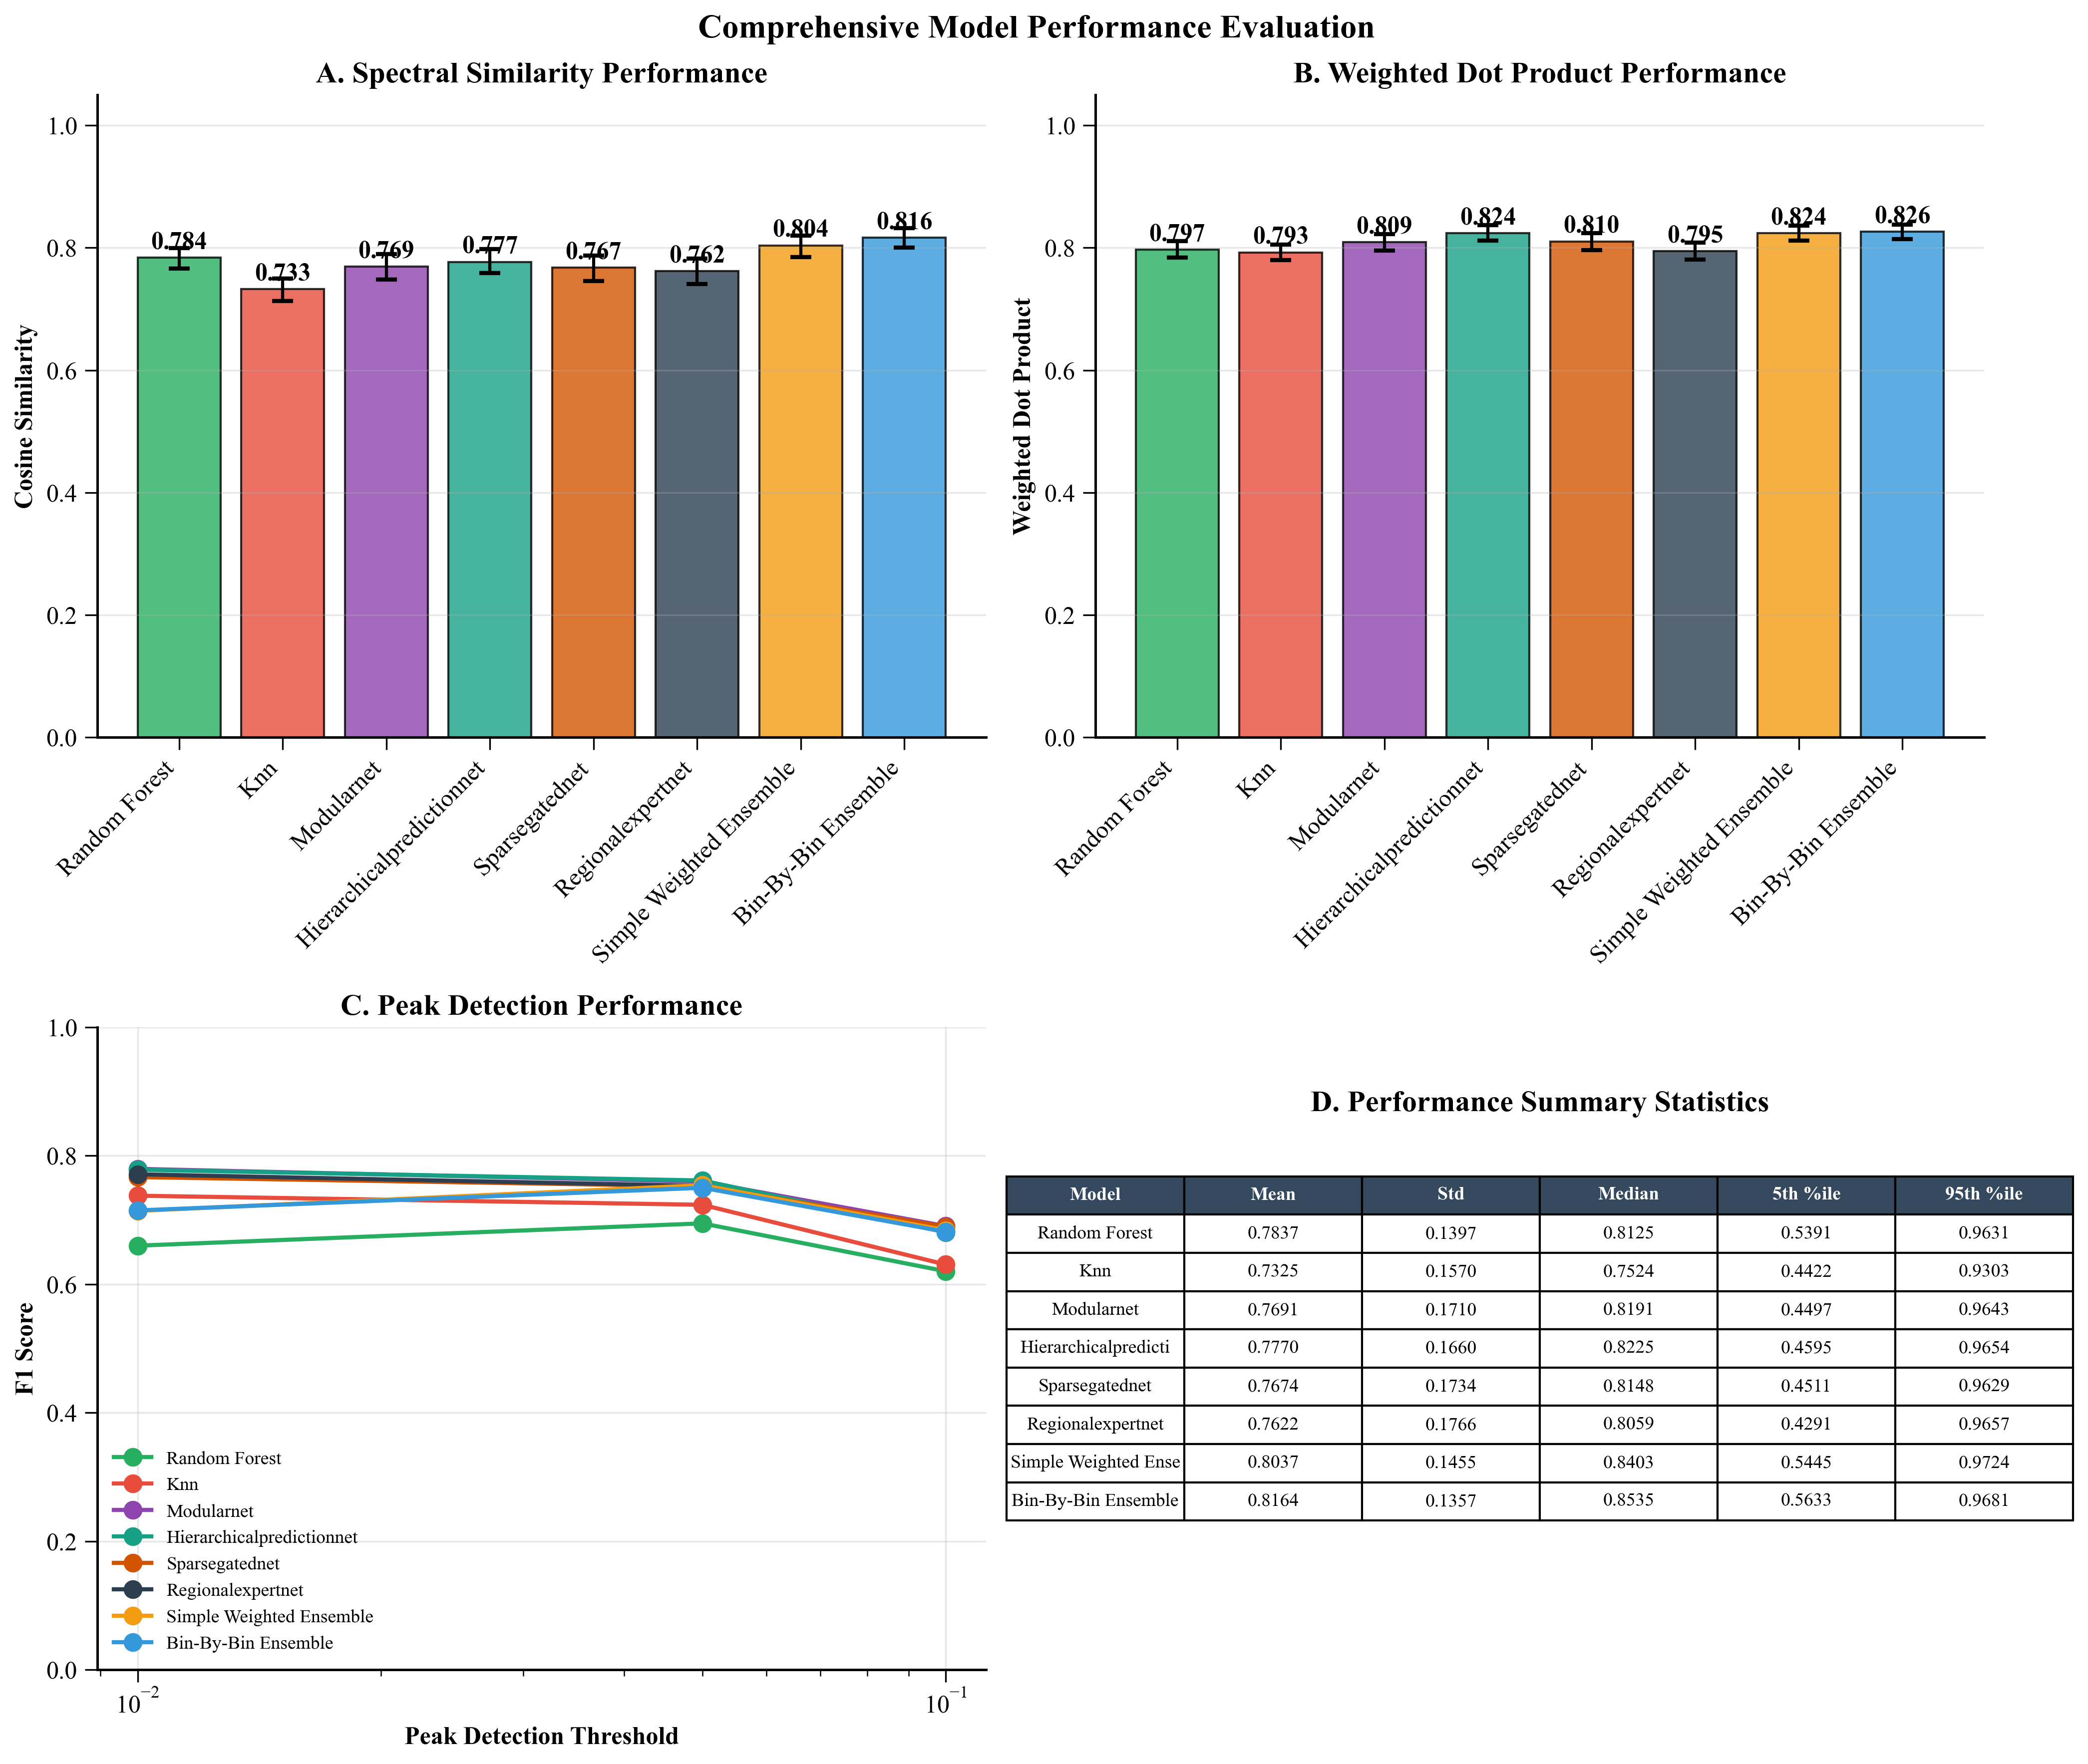

In [10]:
def create_performance_plots(evaluation_results: Dict[str, ModelEvaluationResults]):
    """Create publication-quality performance comparison plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Comprehensive Model Performance Evaluation', fontsize=16, fontweight='bold')
    
    model_names = list(evaluation_results.keys())
    n_models = len(model_names)
    
    # 1. Cosine Similarity with Confidence Intervals
    ax1 = axes[0, 0]
    
    cosine_means = [evaluation_results[m].spectral_metrics.cosine_similarity for m in model_names]
    cosine_cis = [evaluation_results[m].spectral_metrics.cosine_similarity_ci for m in model_names]
    
    x_pos = np.arange(n_models)
    colors = [MODEL_COLORS.get(m, '#95a5a6') for m in model_names]
    
    bars = ax1.bar(x_pos, cosine_means, color=colors, alpha=0.8, edgecolor='black')
    
    for i, (mean, ci) in enumerate(zip(cosine_means, cosine_cis)):
        ax1.errorbar(i, mean, yerr=[[mean - ci[0]], [ci[1] - mean]], 
                    fmt='none', color='black', capsize=5, capthick=2)
    
    for bar, mean in zip(bars, cosine_means):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_ylabel('Cosine Similarity', fontweight='bold')
    ax1.set_title('A. Spectral Similarity Performance', fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([m.replace('_', ' ').title() for m in model_names], rotation=45, ha='right')
    ax1.set_ylim(0, 1.05)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. WDP with Confidence Intervals
    ax2 = axes[0, 1]
    
    wdp_means = [evaluation_results[m].spectral_metrics.weighted_dot_product for m in model_names]
    wdp_cis = [evaluation_results[m].spectral_metrics.weighted_dot_product_ci for m in model_names]
    
    bars2 = ax2.bar(x_pos, wdp_means, color=colors, alpha=0.8, edgecolor='black')
    
    for i, (mean, ci) in enumerate(zip(wdp_means, wdp_cis)):
        ax2.errorbar(i, mean, yerr=[[mean - ci[0]], [ci[1] - mean]], 
                    fmt='none', color='black', capsize=5, capthick=2)
    
    for bar, mean in zip(bars2, wdp_means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('Weighted Dot Product', fontweight='bold')
    ax2.set_title('B. Weighted Dot Product Performance', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([m.replace('_', ' ').title() for m in model_names], rotation=45, ha='right')
    ax2.set_ylim(0, 1.05)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Peak Detection F1 Scores
    ax3 = axes[1, 0]
    
    thresholds = EVAL_CONFIG['evaluation']['peak_thresholds']
    
    for i, model_name in enumerate(model_names):
        f1_scores = [evaluation_results[model_name].peak_detection_metrics[t].f1_score 
                    for t in thresholds]
        ax3.plot(thresholds, f1_scores, 'o-', label=model_name.replace('_', ' ').title(),
                color=colors[i], linewidth=2, markersize=8)
    
    ax3.set_xlabel('Peak Detection Threshold', fontweight='bold')
    ax3.set_ylabel('F1 Score', fontweight='bold')
    ax3.set_title('C. Peak Detection Performance', fontweight='bold')
    ax3.set_xscale('log')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # 4. Performance Summary Statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_data = []
    for model_name in model_names:
        cosines = evaluation_results[model_name].sample_cosine_similarities
        summary_data.append([
            model_name.replace('_', ' ').title()[:20],
            f"{np.mean(cosines):.4f}",
            f"{np.std(cosines):.4f}",
            f"{np.median(cosines):.4f}",
            f"{np.percentile(cosines, 5):.4f}",
            f"{np.percentile(cosines, 95):.4f}"
        ])
    
    table = ax4.table(cellText=summary_data,
                     colLabels=['Model', 'Mean', 'Std', 'Median', '5th %ile', '95th %ile'],
                     cellLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    for i in range(6):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax4.set_title('D. Performance Summary Statistics', fontweight='bold', y=0.85)
    
    plt.tight_layout()
    
    save_path = os.path.join(EVAL_CONFIG['paths']['figures_dir'], 'model_performance_comparison.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nPerformance comparison figure saved to: {save_path}")
    
    plt.show()

create_performance_plots(evaluation_results)

## 11. Performance Distribution Analysis

Analyze the distribution of performance metrics across individual samples.


Distribution analysis figure saved to: ../figures/evaluation/performance_distribution_analysis.png


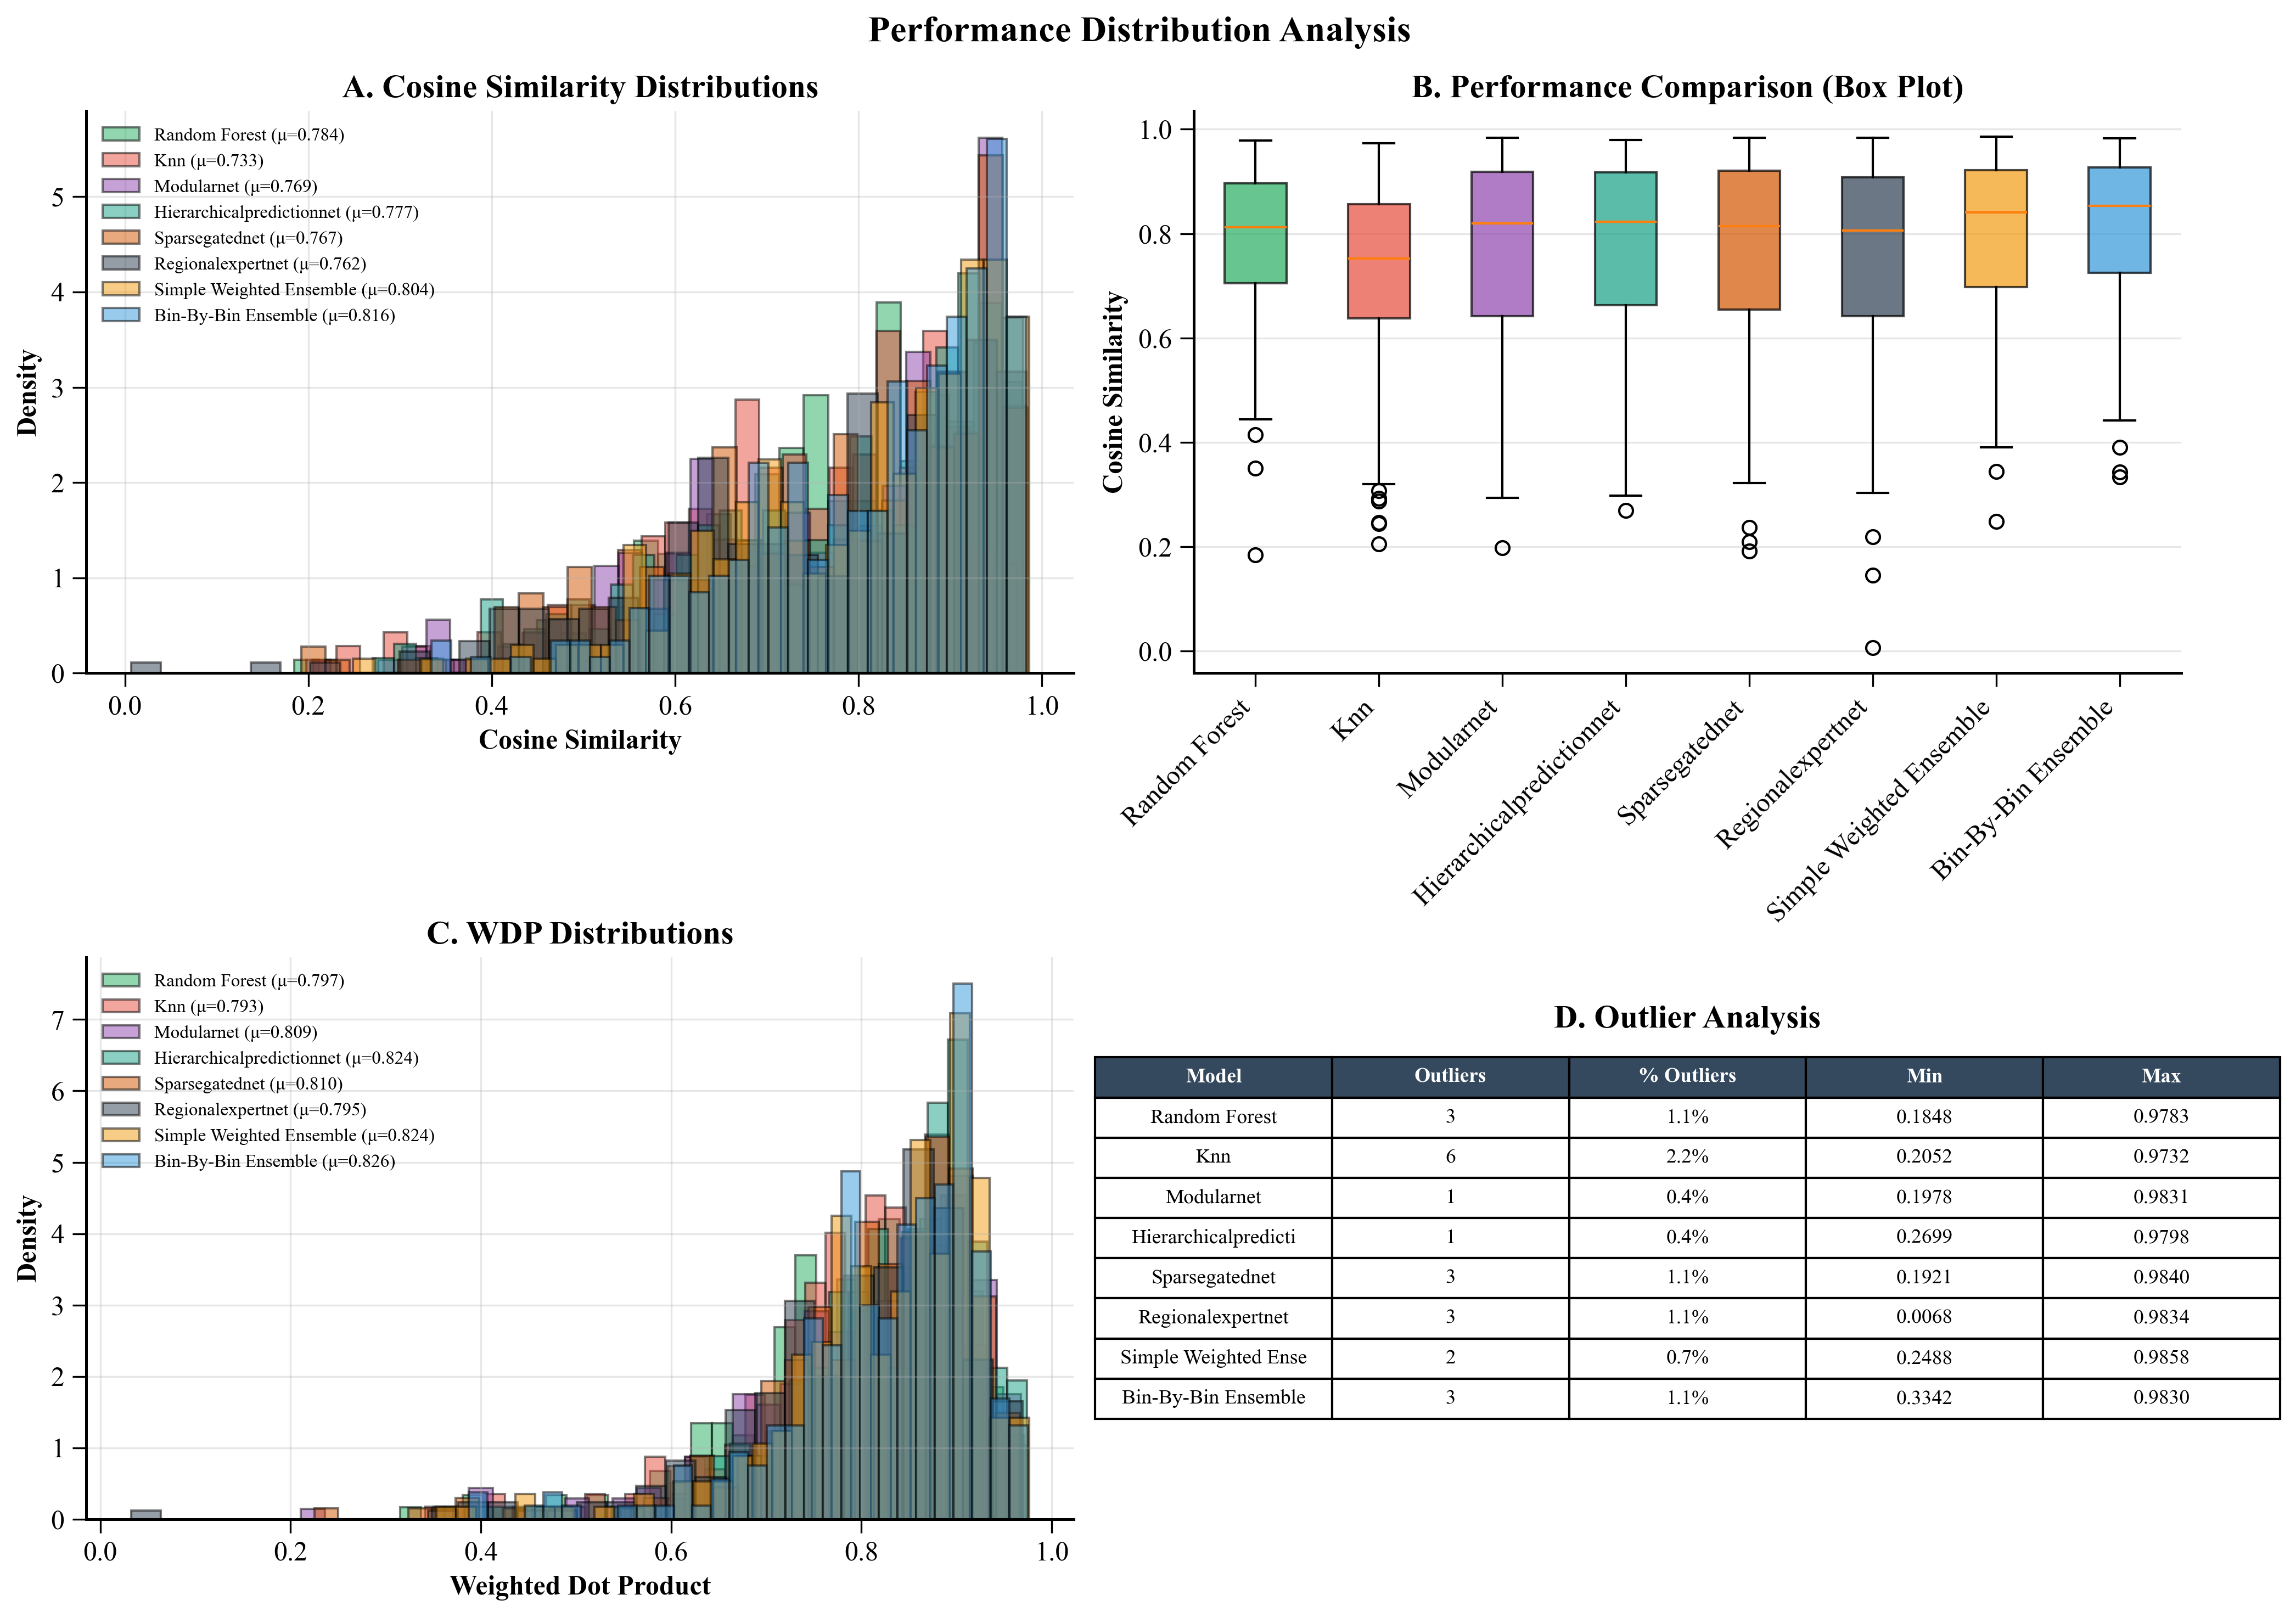


Outlier Analysis:

Random Forest:
  Outliers (1.5*IQR): 3 (1.1%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.1848
  Max cosine similarity: 0.9783

Knn:
  Outliers (1.5*IQR): 6 (2.2%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.2052
  Max cosine similarity: 0.9732

Modularnet:
  Outliers (1.5*IQR): 1 (0.4%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.1978
  Max cosine similarity: 0.9831

Hierarchicalpredictionnet:
  Outliers (1.5*IQR): 1 (0.4%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.2699
  Max cosine similarity: 0.9798

Sparsegatednet:
  Outliers (1.5*IQR): 3 (1.1%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.1921
  Max cosine similarity: 0.9840

Regionalexpertnet:
  Outliers (1.5*IQR): 3 (1.1%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.0068
  Max cosine similarity: 0.9834

Simple Weighted Ensemble:
  Outliers (1.5*IQR): 2 (0.7%)
  Samples < 5th percentile: 14
  Min cosine similarity: 0.2488
  Ma

In [11]:
def analyze_performance_distribution(evaluation_results: Dict[str, ModelEvaluationResults]):
    """Analyze distribution of performance across samples"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Performance Distribution Analysis', fontsize=16, fontweight='bold')
    
    model_names = list(evaluation_results.keys())
    colors = [MODEL_COLORS.get(m, '#95a5a6') for m in model_names]
    
    # 1. Cosine Similarity Distributions
    ax1 = axes[0, 0]
    
    for model_name, color in zip(model_names, colors):
        cosines = evaluation_results[model_name].sample_cosine_similarities
        ax1.hist(cosines, bins=30, alpha=0.5, density=True, 
                label=f"{model_name.replace('_', ' ').title()} (μ={np.mean(cosines):.3f})",
                color=color, edgecolor='black')
    
    ax1.set_xlabel('Cosine Similarity', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.set_title('A. Cosine Similarity Distributions', fontweight='bold')
    ax1.legend(loc='best', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Box Plot Comparison
    ax2 = axes[0, 1]
    
    cosine_data = [evaluation_results[m].sample_cosine_similarities for m in model_names]
    bp = ax2.boxplot(cosine_data, labels=[m.replace('_', ' ').title() for m in model_names],
                    patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Cosine Similarity', fontweight='bold')
    ax2.set_title('B. Performance Comparison (Box Plot)', fontweight='bold')
    ax2.grid(True, axis='y', alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 3. WDP Distributions
    ax3 = axes[1, 0]
    
    for model_name, color in zip(model_names, colors):
        wdps = evaluation_results[model_name].sample_wdp_scores
        ax3.hist(wdps, bins=30, alpha=0.5, density=True, 
                label=f"{model_name.replace('_', ' ').title()} (μ={np.mean(wdps):.3f})",
                color=color, edgecolor='black')
    
    ax3.set_xlabel('Weighted Dot Product', fontweight='bold')
    ax3.set_ylabel('Density', fontweight='bold')
    ax3.set_title('C. WDP Distributions', fontweight='bold')
    ax3.legend(loc='best', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # 4. Outlier Analysis
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    outlier_data = []
    for model_name in model_names:
        cosines = evaluation_results[model_name].sample_cosine_similarities
        q1, q3 = np.percentile(cosines, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers = np.sum((cosines < lower_bound) | (cosines > upper_bound))
        outlier_data.append([
            model_name.replace('_', ' ').title()[:20],
            f"{outliers}",
            f"{outliers/len(cosines)*100:.1f}%",
            f"{np.min(cosines):.4f}",
            f"{np.max(cosines):.4f}"
        ])
    
    table = ax4.table(cellText=outlier_data,
                     colLabels=['Model', 'Outliers', '% Outliers', 'Min', 'Max'],
                     cellLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    for i in range(5):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax4.set_title('D. Outlier Analysis', fontweight='bold', y=0.85)
    
    plt.tight_layout()
    
    save_path = os.path.join(EVAL_CONFIG['paths']['figures_dir'], 'performance_distribution_analysis.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nDistribution analysis figure saved to: {save_path}")
    
    plt.show()
    
    print("\nOutlier Analysis:")
    print("="*60)
    
    for model_name in model_names:
        cosines = evaluation_results[model_name].sample_cosine_similarities
        q1, q3 = np.percentile(cosines, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers = np.sum((cosines < lower_bound) | (cosines > upper_bound))
        worst_5 = np.sum(cosines < np.percentile(cosines, 5))
        
        print(f"\n{model_name.replace('_', ' ').title()}:")
        print(f"  Outliers (1.5*IQR): {outliers} ({outliers/len(cosines)*100:.1f}%)")
        print(f"  Samples < 5th percentile: {worst_5}")
        print(f"  Min cosine similarity: {np.min(cosines):.4f}")
        print(f"  Max cosine similarity: {np.max(cosines):.4f}")

analyze_performance_distribution(evaluation_results)

## 12. Summary Report Generation

Generate a comprehensive summary report of all evaluation results.

In [12]:
def generate_summary_report(evaluation_results: Dict[str, ModelEvaluationResults],
                          statistical_results: Optional[pd.DataFrame] = None):
    """Generate comprehensive evaluation summary report"""
    
    print("\n" + "="*80)
    print("COMPREHENSIVE EVALUATION SUMMARY REPORT")
    print("="*80)
    
    model_names = list(evaluation_results.keys())
    
    sorted_models = sorted(evaluation_results.items(), 
                          key=lambda x: x[1].spectral_metrics.cosine_similarity,
                          reverse=True)
    
    print("\n1. EXECUTIVE SUMMARY")
    print("-"*60)
    
    best_model = sorted_models[0]
    print(f"Best performing model: {best_model[0].replace('_', ' ').title()}")
    print(f"  - Cosine Similarity: {best_model[1].spectral_metrics.cosine_similarity:.4f} "
          f"(95% CI: [{best_model[1].spectral_metrics.cosine_similarity_ci[0]:.4f}, "
          f"{best_model[1].spectral_metrics.cosine_similarity_ci[1]:.4f}])")
    print(f"  - WDP: {best_model[1].spectral_metrics.weighted_dot_product:.4f} "
          f"(95% CI: [{best_model[1].spectral_metrics.weighted_dot_product_ci[0]:.4f}, "
          f"{best_model[1].spectral_metrics.weighted_dot_product_ci[1]:.4f}])")
    
    print("\n2. MODEL RANKINGS")
    print("-"*60)
    print(f"{'Rank':<6} {'Model':<35} {'Cosine Sim':<12} {'WDP':<12} {'F1@0.01'}")
    print("-"*80)
    
    for rank, (model_name, results) in enumerate(sorted_models, 1):
        print(f"{rank:<6} {model_name.replace('_', ' ').title():<35} "
              f"{results.spectral_metrics.cosine_similarity:<12.4f} "
              f"{results.spectral_metrics.weighted_dot_product:<12.4f} "
              f"{results.peak_detection_metrics[0.01].f1_score:.4f}")
    
    print("\n3. DETAILED METRICS")
    print("-"*60)
    
    for model_name, results in sorted_models[:5]:
        print(f"\n{model_name.replace('_', ' ').title()}:")
        print(f"  Spectral Metrics:")
        print(f"    - Cosine Similarity: {results.spectral_metrics.cosine_similarity:.4f} "
              f"[{results.spectral_metrics.cosine_similarity_ci[0]:.4f}, "
              f"{results.spectral_metrics.cosine_similarity_ci[1]:.4f}]")
        print(f"    - WDP: {results.spectral_metrics.weighted_dot_product:.4f} "
              f"[{results.spectral_metrics.weighted_dot_product_ci[0]:.4f}, "
              f"{results.spectral_metrics.weighted_dot_product_ci[1]:.4f}]")
        print(f"    - Spectral Angle: {results.spectral_metrics.spectral_angle:.4f}")
        print(f"    - RMSE: {results.spectral_metrics.root_mean_squared_error:.4f}")
        print(f"  Peak Detection (threshold=0.01):")
        print(f"    - Precision: {results.peak_detection_metrics[0.01].precision:.4f}")
        print(f"    - Recall: {results.peak_detection_metrics[0.01].recall:.4f}")
        print(f"    - F1 Score: {results.peak_detection_metrics[0.01].f1_score:.4f}")
    
    if statistical_results is not None and len(statistical_results) > 0:
        print("\n4. STATISTICAL SIGNIFICANCE")
        print("-"*60)
        
        significant_comparisons = statistical_results[
            statistical_results['Sig (t)'].str.contains('\*', na=False)
        ]
        
        if len(significant_comparisons) > 0:
            print("\nSignificant differences found:")
            for _, row in significant_comparisons.iterrows():
                cohens_d_value = row["Cohen's d"]
                print(f"  - {row['Model 1']} vs {row['Model 2']}: "
                      f"Δ={row['Mean Diff']:+.4f}, p={row['p-value (t)']:.4f}, "
                      f"Cohen's d={cohens_d_value:.3f} ({row['Effect Size']})")
        else:
            print("\nNo statistically significant differences found between models.")
    
    print("\n5. RECOMMENDATIONS")
    print("-"*60)
    
    if len(sorted_models) > 1:
        improvement = (sorted_models[0][1].spectral_metrics.cosine_similarity - 
                      sorted_models[-1][1].spectral_metrics.cosine_similarity)
        print(f"\n✓ The {sorted_models[0][0].replace('_', ' ').title()} model shows the best overall performance")
        print(f"✓ Performance improvement over worst model: {improvement:.4f} ({improvement/sorted_models[-1][1].spectral_metrics.cosine_similarity*100:.1f}%)")
        
        ensemble_models = [m for m in model_names if 'Ensemble' in m]
        if ensemble_models:
            best_ensemble = max(ensemble_models, 
                              key=lambda x: evaluation_results[x].spectral_metrics.cosine_similarity)
            best_individual = max([m for m in model_names if 'Ensemble' not in m],
                                key=lambda x: evaluation_results[x].spectral_metrics.cosine_similarity)
            
            ensemble_cos = evaluation_results[best_ensemble].spectral_metrics.cosine_similarity
            individual_cos = evaluation_results[best_individual].spectral_metrics.cosine_similarity
            
            if ensemble_cos > individual_cos:
                print(f"✓ {best_ensemble} outperforms best individual model by {ensemble_cos - individual_cos:.4f}")
    
    print("\n" + "="*80)
    print("Report generation complete")
    
    report_path = os.path.join(EVAL_CONFIG['paths']['results_dir'], 'evaluation_report.txt')
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("COMPREHENSIVE EVALUATION SUMMARY REPORT\n")
        f.write("="*80 + "\n\n")
        
        f.write("1. EXECUTIVE SUMMARY\n")
        f.write("-"*60 + "\n\n")
        f.write(f"Best performing model: {best_model[0].replace('_', ' ').title()}\n")
        f.write(f"  - Cosine Similarity: {best_model[1].spectral_metrics.cosine_similarity:.4f} ")
        f.write(f"(95% CI: [{best_model[1].spectral_metrics.cosine_similarity_ci[0]:.4f}, ")
        f.write(f"{best_model[1].spectral_metrics.cosine_similarity_ci[1]:.4f}])\n")
        
        f.write("\n2. MODEL RANKINGS\n")
        f.write("-"*60 + "\n")
        f.write(f"{'Rank':<6} {'Model':<35} {'Cosine Sim':<12} {'WDP':<12} {'F1@0.01'}\n")
        f.write("-"*80 + "\n")
        
        for rank, (model_name, results) in enumerate(sorted_models, 1):
            f.write(f"{rank:<6} {model_name.replace('_', ' ').title():<35} ")
            f.write(f"{results.spectral_metrics.cosine_similarity:<12.4f} ")
            f.write(f"{results.spectral_metrics.weighted_dot_product:<12.4f} ")
            f.write(f"{results.peak_detection_metrics[0.01].f1_score:.4f}\n")
    
    print(f"\nReport saved to: {report_path}")

generate_summary_report(evaluation_results, 
                       statistical_results if 'statistical_results' in locals() else None)


COMPREHENSIVE EVALUATION SUMMARY REPORT

1. EXECUTIVE SUMMARY
------------------------------------------------------------
Best performing model: Bin-By-Bin Ensemble
  - Cosine Similarity: 0.8164 (95% CI: [0.8001, 0.8324])
  - WDP: 0.8264 (95% CI: [0.8142, 0.8381])

2. MODEL RANKINGS
------------------------------------------------------------
Rank   Model                               Cosine Sim   WDP          F1@0.01
--------------------------------------------------------------------------------
1      Bin-By-Bin Ensemble                 0.8164       0.8264       0.7148
2      Simple Weighted Ensemble            0.8037       0.8242       0.7141
3      Random Forest                       0.7837       0.7967       0.6600
4      Hierarchicalpredictionnet           0.7770       0.8243       0.7782
5      Modularnet                          0.7691       0.8089       0.7795
6      Sparsegatednet                      0.7674       0.8104       0.7668
7      Regionalexpertnet               